![Meme](./Image.png)

In [ ]:
# https://www.kaggle.com/competitions/titanic/overview

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score

Train = pd.read_csv('./Train.csv')
Test = pd.read_csv('./Test.csv')

PassengerId = Test['PassengerId']

In [1877]:
missingValuesTrain = pd.isnull(Train).sum().to_string()
print(missingValuesTrain)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2


In [1878]:
missingValuesTest = pd.isnull(Test).sum().to_string()
print(missingValuesTest)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0


In [1879]:
KBD_Fare = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile') 
KBD_Fare.fit(Train[['Fare']])

KBD_Age = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='quantile')
Train['Age'] = Train['Age'].fillna(Train['Sex'].map(Train.groupby('Sex')['Age'].median()))
Test['Age'] = Test['Age'].fillna(Test['Sex'].map(Test.groupby('Sex')['Age'].median()))
KBD_Age.fit(Train[['Age']])

for ds in [Train, Test]:
    # Sex
    ds['Sex'] = ds['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # FamSize
    ds['FamSize'] = (ds['SibSp'] + ds['Parch'] + 1).astype(int)

    # Cabin
    ds['HasCabin'] = ds['Cabin'].apply(lambda x: 0 if type(x) == float else 1).astype(int)

    # Embarked
    ds['Embarked'] = (ds['Embarked'].fillna('S').map({'S': 0, 'C': 1, 'Q': 2}).astype(int))

    # Title
    ds['Title'] = ds['Name'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)
    ds['Title'] = ds['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Prestige')
    ds['Title'] = ds['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})
    ds['Title'] = (ds['Title'].map({'Mr': 1,'Miss': 2,'Mrs': 3,'Master': 4,'Prestige': 5}).fillna(0).astype(int))

    # IsAlone
    ds['IsAlone'] = (ds['FamSize'] == 1).astype(int)
    
    # Age
    ds['Age'] = KBD_Age.transform(ds[['Age']]).astype(int)

    # Fare
    ds['Fare'] = ds['Fare'].fillna(Train['Fare'].median())
    ds['Fare'] = KBD_Fare.transform(ds[['Fare']]).astype(int)

    # Drop
    ds.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

# Age: {0: '[0.42, 19.00)', 1: '[19.00, 25.00)', 2: '[25.00, 29.00)', 3: '[29.00, 31.00)', 4: '[31.00, 40.50)', 5: '[40.50, 80.00]'}
# Fare: {0: '[0.00, 7.78)', 1: '[7.78, 8.66)', 2: '[8.66, 14.45)', 3: '[14.45, 26.00)', 4: '[26.00, 52.37)', 5: '[52.37, 512.33]'}

<Axes: title={'center': 'Pearson Correlation of Features'}>

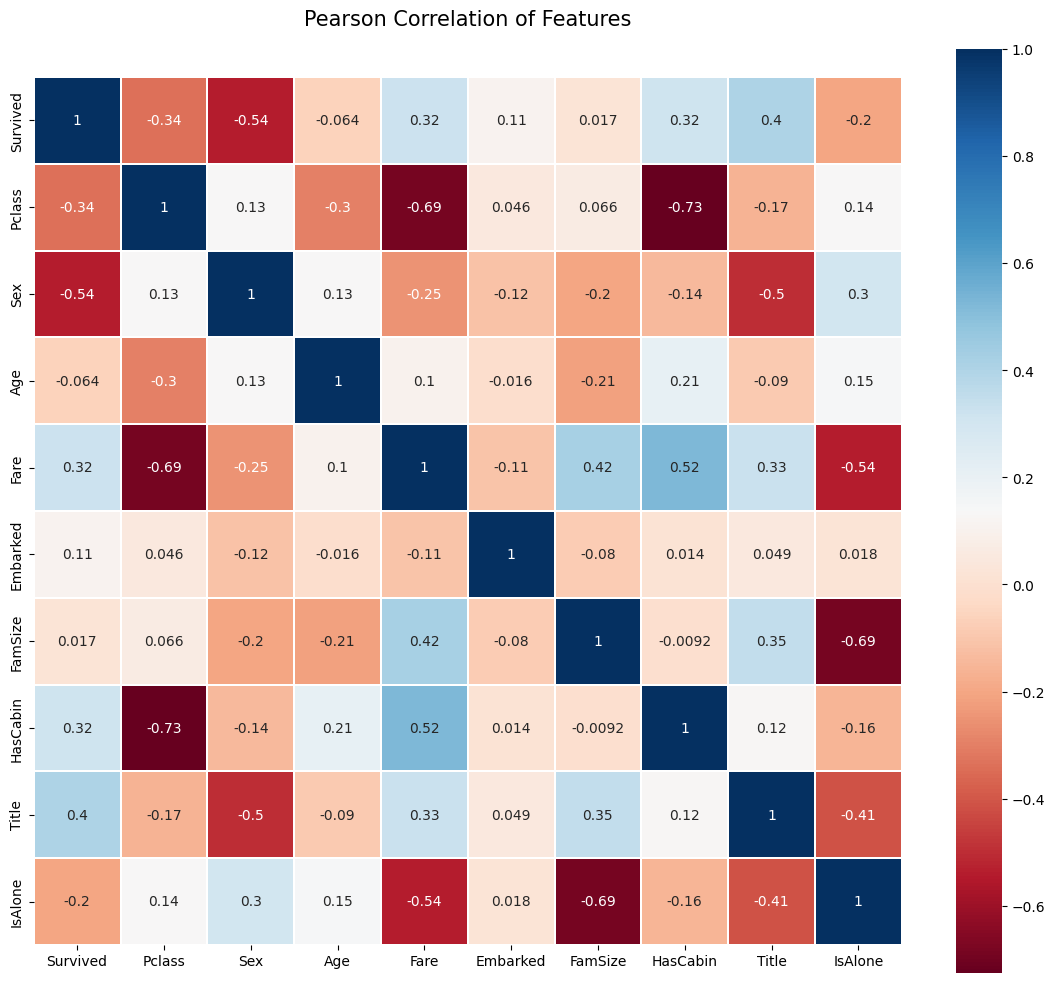

In [1880]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

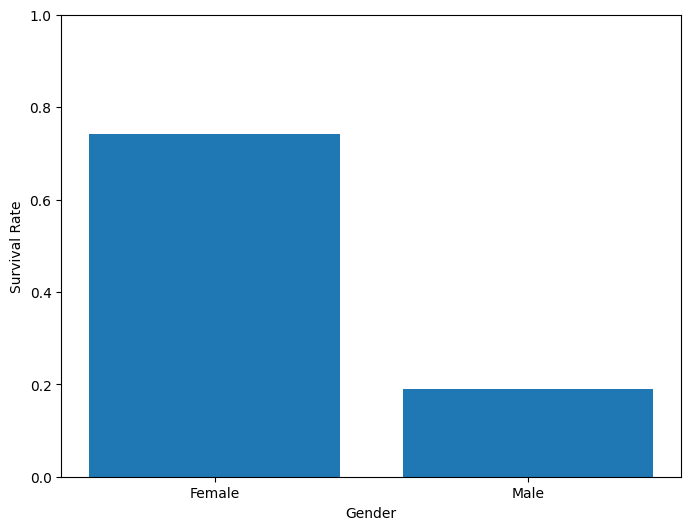

Percentage of Females: 74.20382165605095
Percentage of Males: 18.890814558058924


In [1881]:
# Sex
F = Train[Train['Sex'] == 0]['Survived'].mean()
M = Train[Train['Sex'] == 1]['Survived'].mean()

plt.figure(figsize=(8, 6))
plt.bar(['Female', 'Male'], [F, M])
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

print('Percentage of Females:', F * 100)
print('Percentage of Males:', M * 100)

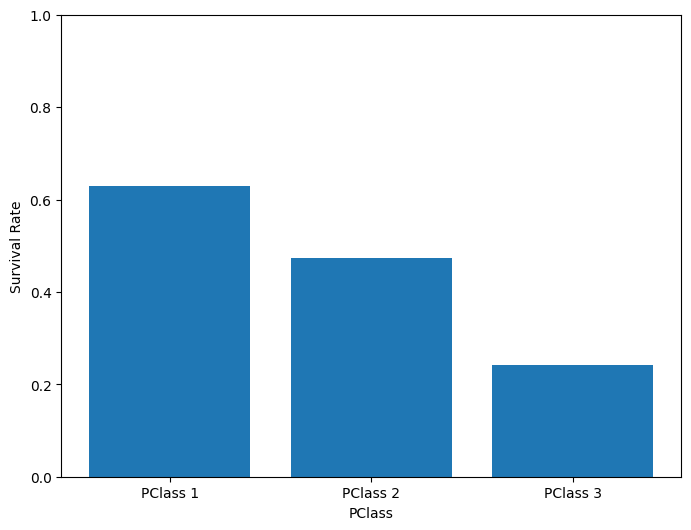

Percentage of PClass 1: 62.96296296296296
Percentage of PClass 2: 47.28260869565217
Percentage of PClass 3: 24.236252545824847


In [1882]:
# PClass
PC1 = Train[Train['Pclass'] == 1]['Survived'].mean()
PC2 = Train[Train['Pclass'] == 2]['Survived'].mean()
PC3 = Train[Train['Pclass'] == 3]['Survived'].mean()

plt.figure(figsize=(8, 6))
plt.bar(['PClass 1', 'PClass 2', 'PClass 3'], [PC1, PC2, PC3])
plt.xlabel('PClass')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

print('Percentage of PClass 1:', PC1 * 100)
print('Percentage of PClass 2:', PC2 * 100)
print('Percentage of PClass 3:', PC3 * 100)

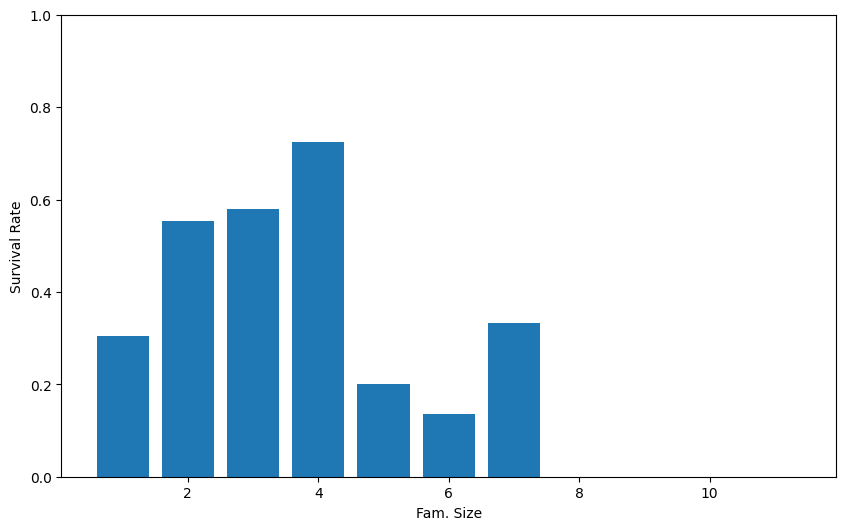

Percentage of Fam. Size 1: 30.353817504655495
Percentage of Fam. Size 2: 55.27950310559007
Percentage of Fam. Size 3: 57.84313725490197
Percentage of Fam. Size 4: 72.41379310344827
Percentage of Fam. Size 5: 20.0
Percentage of Fam. Size 6: 13.636363636363635
Percentage of Fam. Size 7: 33.33333333333333
Percentage of Fam. Size 8: 0.0
Percentage of Fam. Size 11: 0.0


In [1883]:
# FamSize

# SibSp — Siblings e Spouse
# Parch — Parents e Children

FS = Train.groupby('FamSize')['Survived'].mean()

famSizes = FS.index

plt.figure(figsize=(10, 6))
plt.bar(famSizes, FS.values)
plt.xlabel('Fam. Size')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

for famSize, r in zip(famSizes, FS.values): print(f'Percentage of Fam. Size {famSize}:', r * 100)

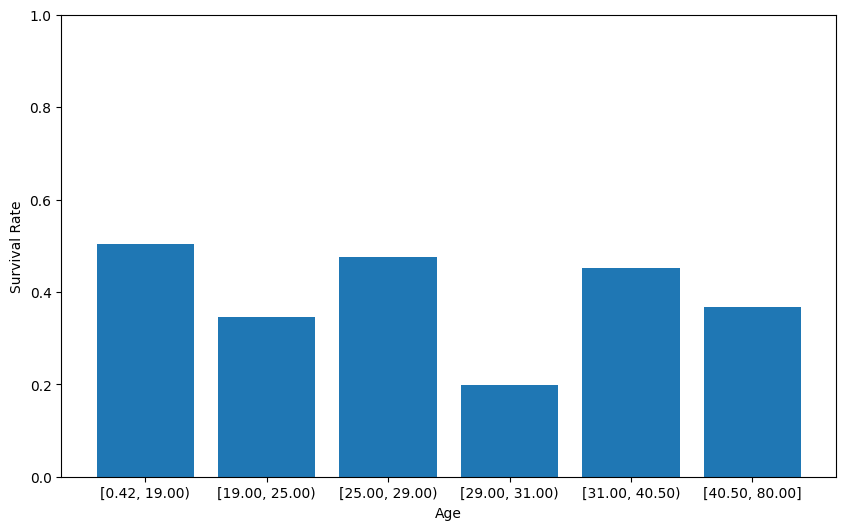

Percentage of Age [0.42, 19.00): 50.35971223021583
Percentage of Age [19.00, 25.00): 34.53237410071942
Percentage of Age [25.00, 29.00): 47.482014388489205
Percentage of Age [29.00, 31.00): 19.883040935672515
Percentage of Age [31.00, 40.50): 45.09803921568628
Percentage of Age [40.50, 80.00]: 36.666666666666664


In [1884]:
# Age
A = Train.groupby('Age')['Survived'].mean()

ageCategories = ['[0.42, 19.00)', '[19.00, 25.00)', '[25.00, 29.00)', '[29.00, 31.00)', '[31.00, 40.50)', '[40.50, 80.00]']

plt.figure(figsize=(10, 6))
plt.bar(ageCategories, A.values)
plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

for ageCategory, r in zip(ageCategories, A.values): print(f"Percentage of Age {ageCategory}:", r * 100)

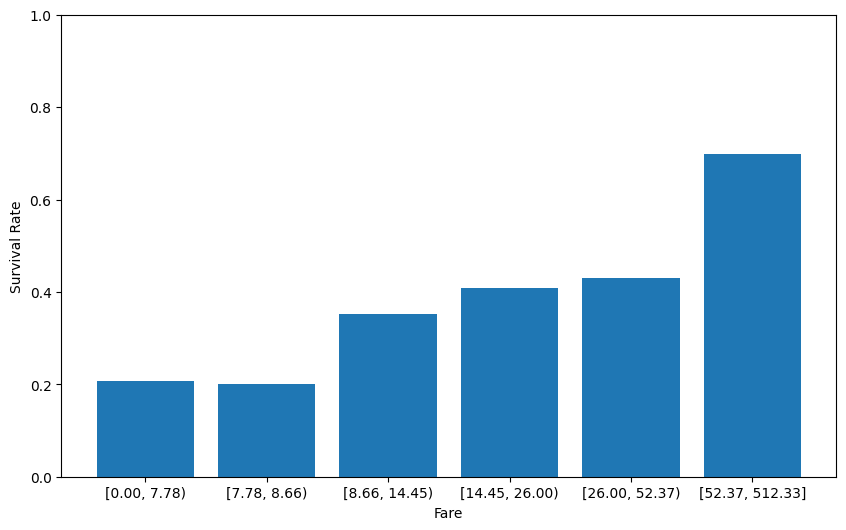

Percentage of Fare [0.00, 7.78): 20.714285714285715
Percentage of Fare [7.78, 8.66): 20.0
Percentage of Fare [8.66, 14.45): 35.172413793103445
Percentage of Fare [14.45, 26.00): 40.8
Percentage of Fare [26.00, 52.37): 42.93785310734463
Percentage of Fare [52.37, 512.33]: 69.79865771812081


In [1885]:
# Fare
F = Train.groupby('Fare')['Survived'].mean()

fareCategories = ['[0.00, 7.78)', '[7.78, 8.66)', '[8.66, 14.45)', '[14.45, 26.00)', '[26.00, 52.37)', '[52.37, 512.33]']

plt.figure(figsize=(10, 6))
plt.bar(fareCategories, F.values)
plt.xlabel('Fare')
plt.ylabel('Survival Rate')
plt.ylim(0, 1) 
plt.show()

for fareCategory, r in zip(fareCategories, F.values): print(f"Percentage of Fare {fareCategory}:", r * 100)

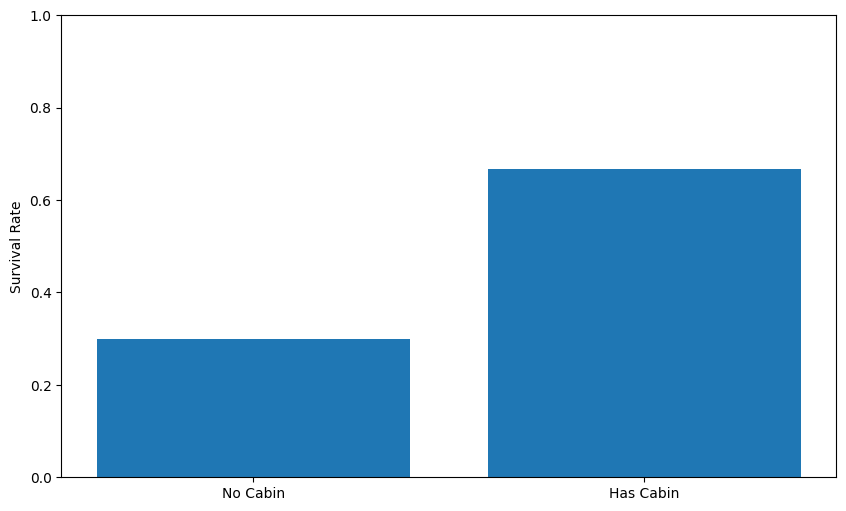

Percentage of No Cabin: 29.985443959243085
Percentage of Has Cabin: 66.66666666666666


In [1886]:
# Has Cabin
HC = Train.groupby('HasCabin')['Survived'].mean()

hasCabinCategories = ['No Cabin', 'Has Cabin']

plt.figure(figsize=(10, 6))
plt.bar(hasCabinCategories, HC.values)
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

for hasCabinCategory, r in zip(hasCabinCategories, HC.values): print(f"Percentage of {hasCabinCategory}:", r * 100)

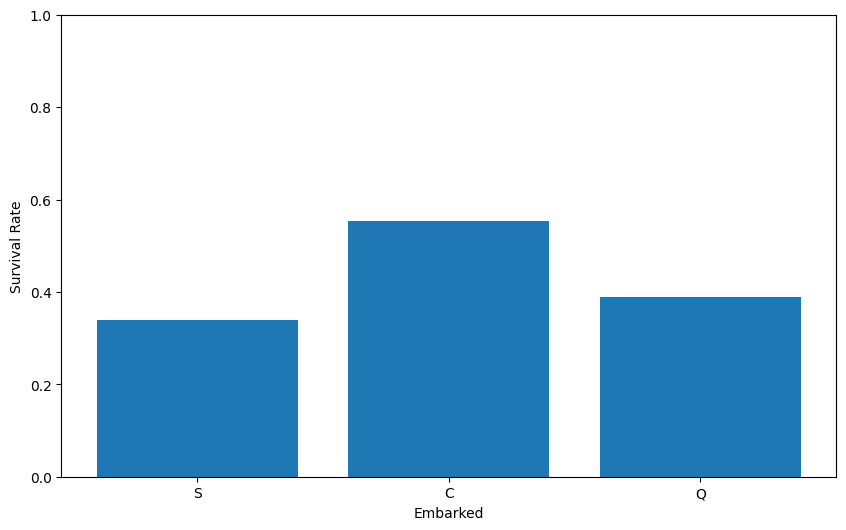

Percentage of Embarked S: 33.90092879256966
Percentage of Embarked C: 55.35714285714286
Percentage of Embarked Q: 38.961038961038966


In [1887]:
# Embarked
E = Train.groupby('Embarked')['Survived'].mean()

embarkedCategories = ['S', 'C', 'Q']

# S = Southampton (Inglaterra) - 3
# C = Cherbourg (França) - 1
# Q = Queenstown (Irlanda) - 2

plt.figure(figsize=(10, 6))
plt.bar(embarkedCategories, E.values)
plt.xlabel('Embarked')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

for embarkedCategory, r in zip(embarkedCategories, E.values): print(f"Percentage of Embarked {embarkedCategory}:", r * 100)

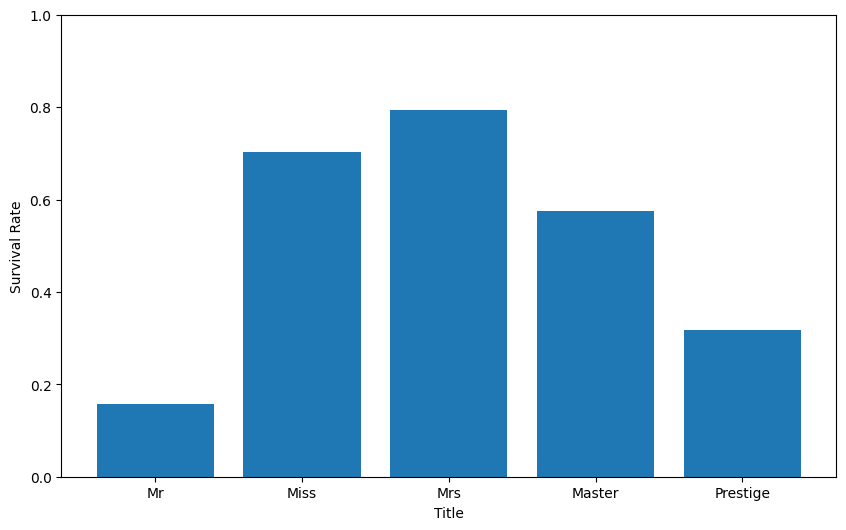

Percentage of Title Mr: 100.0
Percentage of Title Miss: 15.667311411992262
Percentage of Title Mrs: 70.27027027027027
Percentage of Title Master: 79.36507936507937
Percentage of Title Prestige: 57.49999999999999


In [1888]:
# Title
T = Train.groupby('Title')['Survived'].mean()

titleCategories = ['Mr', 'Miss', 'Mrs', 'Master', 'Prestige']

# Mr - Homem Adulto.
# Miss - Mulher Solteira.
# Mrs - Mulher Casada
# Master - Menino.

plt.figure(figsize=(10, 6))
plt.bar(titleCategories, T.reindex([1, 2, 3, 4, 5]).values)
plt.xlabel('Title')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.show()

for titleCategory, r in zip(titleCategories, T.values): print(f"Percentage of Title {titleCategory}:", r * 100)

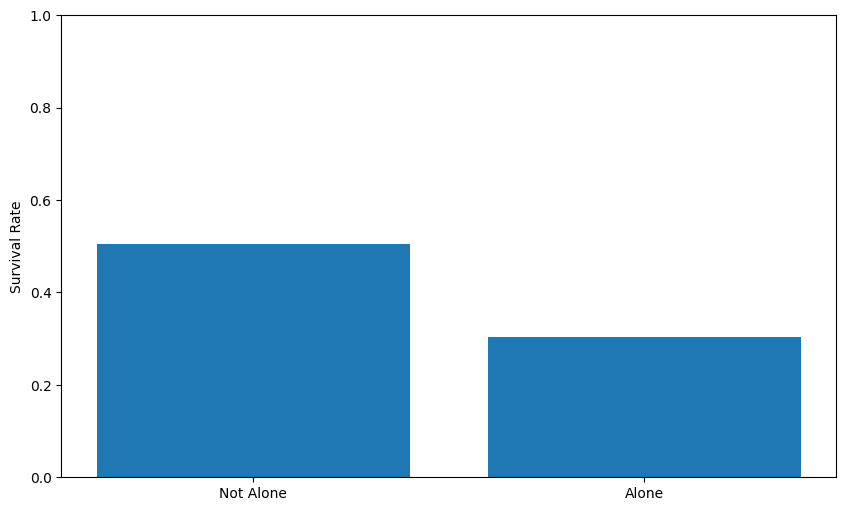

Percentage of Not Alone: 50.56497175141242
Percentage of Alone: 30.353817504655495


In [1889]:
# IsAlone
A = Train.groupby('IsAlone')['Survived'].mean()

isAloneCategories = ['Not Alone', 'Alone']

# Homens Adultos

plt.figure(figsize=(10, 6))
plt.bar(isAloneCategories, A.values)
plt.ylabel('Survival Rate')
plt.ylim(0, 1) 
plt.show()

for isAloneCategory, r in zip(isAloneCategories, A): print(f"Percentage of {isAloneCategory}:", r * 100)

In [ ]:
def plotGraphs(n, r):
    plt.figure(figsize=(8, 4)) 
    plt.title(n)
    plt.xticks([0, 1, 2, 3], ["KNN", "Logistic Regression", "Decision Tree", "Random Forest"], rotation=45)
    for bar in plt.bar([0, 1, 2, 3] , r): plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.3f}', ha='center', va='bottom')
    plt.show()

def printAccuracy(YTrue, mResults):
    r = []
    for e in mResults: r.append(accuracy_score(YTrue, e['YPred']))
    plotGraphs("Accuracies", r)
    
def printRecall(YTrue, mResults):
    r = []
    for e in mResults: r.append(recall_score(YTrue, e['YPred']))
    plotGraphs("Recalls", r)

def printPrecision(YTrue, mResults):
    r = []
    for e in mResults: r.append(precision_score(YTrue, e['YPred']))
    plotGraphs("Precisions", r)
    
def printF1(YTrue, mResults):
    r = []
    for e in mResults: r.append(f1_score(YTrue, e['YPred']))
    plotGraphs("F1 Scores", r)
    
def printROCAUC(YTrue, mResults):
    r = []
    for e in mResults: r.append(roc_auc_score(YTrue, e['YPred']))
    plotGraphs("ROC AUC Scores", r)
    
def printAP(YTrue, mResults):
    r = []
    for e in mResults: r.append(average_precision_score(YTrue, e['YPred']))
    plotGraphs("AP Scores", r)

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(Train.drop(['Survived'], axis=1), Train["Survived"], test_size = 0.25, random_state = 0)

In [ ]:
# KNN Classifier
KNN = KNeighborsClassifier(n_neighbors=18)
KNN.fit(XTrain, YTrain)
YPredKNN = KNN.predict(XTest)
YPredProbaKNN = KNN.predict_proba(XTest)[:, 1]

# Random Forest
RandomForest = RandomForestClassifier()
RandomForest.fit(XTrain, YTrain)
YPredRandomForest = RandomForest.predict(XTest)
YPredProbaRandomForest = RandomForest.predict_proba(XTest)[:, 1]

# Logistic Regression
LogReg = LogisticRegression()
LogReg.fit(XTrain, YTrain)
YPredLogReg = LogReg.predict(XTest)
YPredProbaLogReg = LogReg.predict_proba(XTest)[:, 1]

# Decision Tree Classifier
DecisionTree = DecisionTreeClassifier(min_samples_leaf=2)
DecisionTree.fit(XTrain, YTrain)
YPredDecisionTree = DecisionTree.predict(XTest)
YPredProbaDecisionTree = DecisionTree.predict_proba(XTest)[:, 1]

mResults = [
    {'name': "KNN", 'YPred': YPredKNN, 'YPredProba': YPredProbaKNN},
    {'name': "Logistic Regression", 'YPred': YPredLogReg, 'YPredProba': YPredProbaLogReg},
    {'name': "Decision Tree",'YPred': YPredDecisionTree, 'YPredProba': YPredProbaDecisionTree},
    {'name': "Random Forest", 'YPred': YPredRandomForest, 'YPredProba': YPredProbaRandomForest}
]

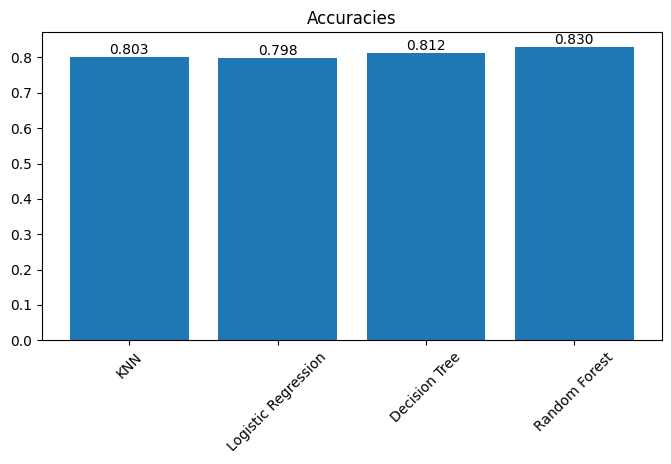

In [1893]:
# Accuracy
printAccuracy(YTest, mResults)

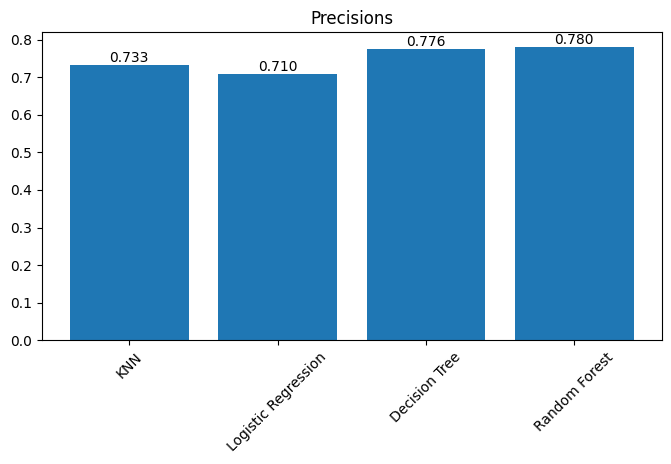

In [1894]:
# Precision
printPrecision(YTest, mResults)

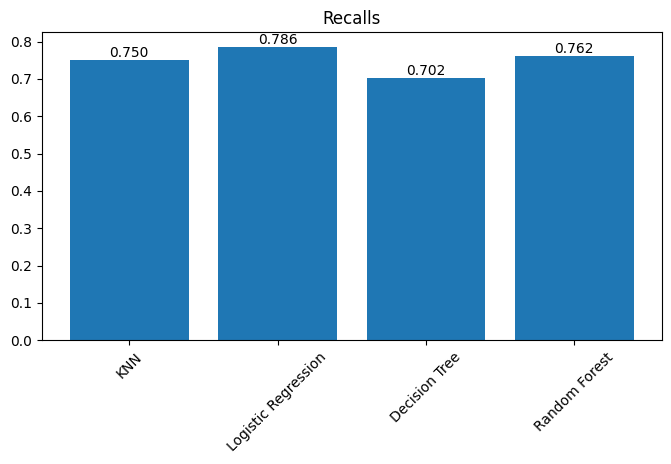

In [1895]:
# Recall
printRecall(YTest, mResults)

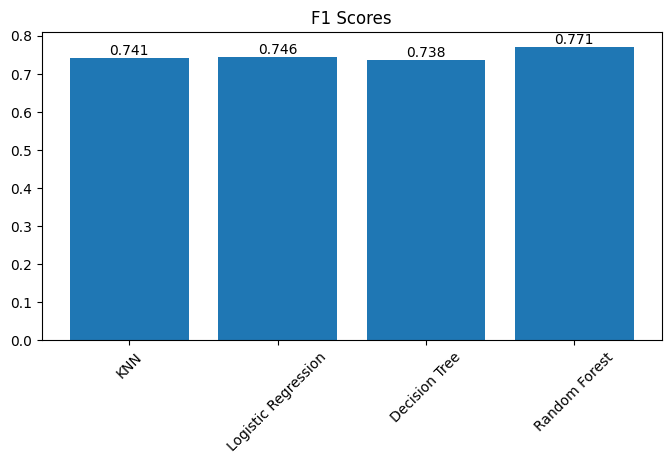

In [1896]:
# F1 Score
printF1(YTest, mResults)

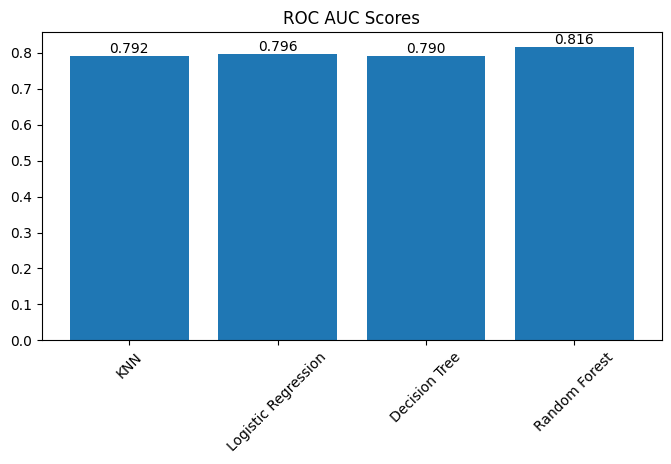

In [1897]:
# ROC AUC Score
printROCAUC(YTest, mResults)

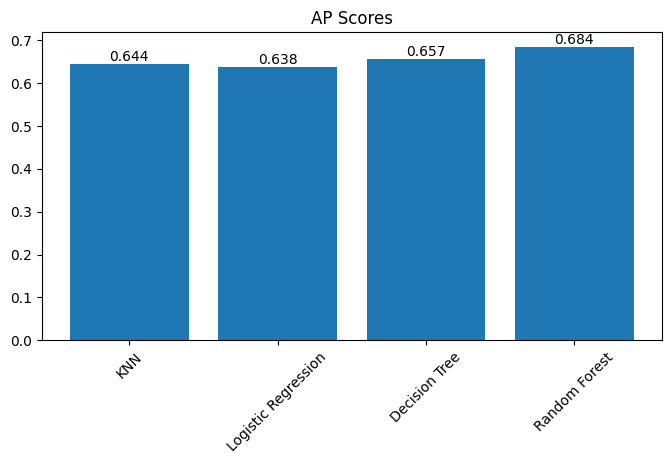

In [1898]:
# AP Score
printAP(YTest, mResults)

In [1899]:
pd.DataFrame({ 'PassengerId' : PassengerId, 'Survived': KNN.predict(Test) }).to_csv('Submission_KNN.csv', index=False) 

In [1900]:
pd.DataFrame({ 'PassengerId' : PassengerId, 'Survived': LogReg.predict(Test) }).to_csv('Submission_LogReg.csv', index=False) 

In [1901]:
pd.DataFrame({ 'PassengerId' : PassengerId, 'Survived': DecisionTree.predict(Test) }).to_csv('Submission_DecisionTree.csv', index=False) 

In [1902]:
pd.DataFrame({ 'PassengerId' : PassengerId, 'Survived': RandomForest.predict(Test) }).to_csv('Submission_RandomForest.csv', index=False) 